# Context

In [11]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

We consider a present-biased model of when individuals start saving for retirement. Crucial to this model is that there is a opt-in cost of starting to save which might be due to status quo bias. The individual is present-biased a la Laibson and is naive about it (thinks next year he will be EDU). We want to measure the optimal time when he will start saving. 

# Preferences

The agent has $(\beta,\delta)$ preferences with CRRA utility ($\gamma$ is the relative risk aversion coefficient). We take the following values

In [12]:
beta = 0.8
delta = 0.95
gamma = 0.75

In [13]:
def u(c,gamma):
    if gamma==1.0:
        return np.log(c)
    else :
        return  c**(1.0-gamma)/(1.0-gamma)

# Ressources

The agent has income which grows and then drops at retirement. He starts making decisions at age 25 (t=0). He lives for 55 years (dies at 80) with retirement at 40 (age 65). He starts off with no wealth. He can make one choice during working years: save in a retirement account a fraction $s$ of his income. Upon retiring, he gets gets annuity income from how much he has accumulated. The employer matches his contributions with 50 cents on the dollar of contribution. He faces a one-time cost of starting contributions, $k$. Once he started, he always saves $s$. 

In [14]:
R = 1.0/delta
r = R-1.0
T = 55
ret = 40
base = 30e3
g = 0.01
rep = 0.4
income = [base*np.exp(g*t) for t in range(T)]
for t in range(T):
    if (t>=ret):
        income[t] = income[ret-1]*rep
w0 = 0.0
age = [25+t for t in range(T)]
nw = 500
wmin = 0.0
wmax = 5e5
gw = np.linspace(wmin,wmax,nw)
s = 0.06
mu = 0.5
k = 2500.0

# The EDU Case

The Bellman equation for the pre-retirement years ($t<t_r$) if $w_t=0$ is $$ V_{t}(0) = max(V^0_{t},V^1_{t}) $$ where $$ V^0_{t} = u(y_t) + \delta V_{t+1}(0) $$
and $$V^1_{t} = u(y_t - sy_t - k) + \delta V_{t+1}(Rs(1+\mu y_t))$$

while if $w_t>0$, $$ V_{t}(w_t) = u(y_t - sy_t) + \delta V_{t+1}(R(w_t + s(1+\mu)y_t)) $$

In the retirement years ($t\ge t_r$), we have
$$V_{t}(w_t) = \sum_{q=0}^{T-t_r} \delta^q u(y_{t+q} + a(w_t)) $$

where $a(w_t)$ is annuity income from retirement savings $w_t$ paid for $T-t_r$ at interest rate $r$. From basic finance calculus we have that $w_t = a(w_t)\frac{1-R^{-(T-t_r)}}{r}$ which implies that $a(w_t) = \frac{r}{1-R^{-(T-t_r)}}w_t $.



## Solution to the EDU Problem

In [15]:
V = np.zeros((nw,ret))
sopt = np.zeros((nw,ret))
for i,w in enumerate(gw):
    ann = r/(1.0-R**(ret-T))*w
    V[i,ret-1] = np.sum([(delta**q) * u(income[ret+q-1] + ann,gamma) for q in range(T-ret)])
    if w==0:
        sopt[i,ret-1] = 0.0
    else :
        sopt[i,ret-1] = 1.0

In [16]:
for t in reversed(range(ret-1)):
    Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
    for i,w in enumerate(gw):
        ww = R*(w+s*(1.0+mu)*income[t])
        if (w==0.0):
            v0 = u(income[t],gamma) + delta * V[0,t+1]
            v1 = u(income[t] - s*income[t] - k,gamma) + delta*Ev(ww)
            if (v1>v0):
                sopt[i,t] = 1.0
                V[i,t] = v1
            else :
                V[i,t] = v0
        else :
            V[i,t] = u(income[t] - s*income[t],gamma) + delta*Ev(ww)
            sopt[i,t] = 1.0
            
            
   

# Present-Bias (Naive)

With present bias preferences, the agent thinks that he will get $V_{t+1}$ from EDU in the next period. But he discounts at rate $\beta\delta$ to make decisions. We implement this here. 

In [17]:
spb = np.zeros((nw,ret))
for t in reversed(range(ret-1)):
    Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
    for i,w in enumerate(gw):
        ww = R*(w+s*(1.0+mu)*income[t])
        if (w==0.0):
            v0 = u(income[t],gamma) + beta*delta * V[0,t+1]
            v1 = u(income[t] - s*income[t] - k,gamma) + beta*delta*Ev(ww)
            if (v1>v0):
                spb[i,t] = 1.0
        else :
            spb[i,t] = 1.0

# Comparison of Solutions

We can compute solutions by looking at when individuals switch ($s$ goes from 0 to 1)

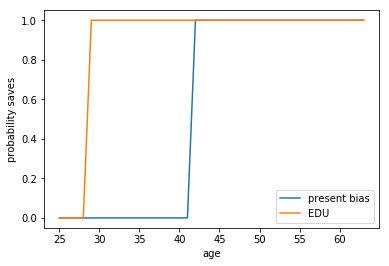

In [18]:
plt.figure()
plt.plot(age[:ret-1],spb[0,:ret-1],label='present bias')
plt.plot(age[:ret-1],sopt[0,:ret-1],label='EDU')
plt.xlabel('age')
plt.ylabel('probability saves')
plt.legend()
plt.show()

# Encapsulating the solution in a function

In [19]:
def solve_edu(delta,gamma,k,s,mu):
    V = np.zeros((nw,ret))
    sopt = np.zeros((nw,ret))
    for i,w in enumerate(gw):
        ann = r/(1.0-R**(ret-T))*w
        V[i,ret-1] = np.sum([(delta**q) * u(income[ret+q-1] + ann,gamma) for q in range(T-ret)])
        if w==0:
            sopt[i,ret-1] = 0.0
        else :
            sopt[i,ret-1] = 1.0
    for t in reversed(range(ret-1)):
        Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
        for i,w in enumerate(gw):
            ww = R*(w+s*(1.0+mu)*income[t])
            if (w==0.0):
                v0 = u(income[t],gamma) + delta * V[0,t+1]
                v1 = u(income[t] - s*income[t] - k,gamma) + delta*Ev(ww)
                if (v1>v0):
                    sopt[i,t] = 1.0
                    V[i,t] = v1
                else :
                    V[i,t] = v0
            else :
                V[i,t] = u(income[t] - s*income[t],gamma) + delta*Ev(ww)
                sopt[i,t] = 1.0
    ageopt = 0
    for t in range(ret-1):
        if (sopt[0,t]==1.0):
            ageopt = t
            break
    return ageopt,V
    

In [20]:
def solve_pbu(beta,delta,gamma,k,s,mu,V):
    spb = np.zeros((nw,ret))
    for t in reversed(range(ret-1)):
        Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
        for i,w in enumerate(gw):
            ww = R*(w+s*(1.0+mu)*income[t])
            if (w==0.0):
                v0 = u(income[t],gamma) + beta*delta * V[0,t+1]
                v1 = u(income[t] - s*income[t] - k,gamma) + beta*delta*Ev(ww)
                if (v1>v0):
                    spb[i,t] = 1.0
            else :
                spb[i,t] = 1.0
    ageopt = 0
    for t in range(ret-1):
        if (spb[0,t]==1.0):
            ageopt = t
            break
    return ageopt

# Study of the Variation with Respect to Parameters

## Variation with switching cost

In [21]:
ks = np.linspace(0.0,5000.0,10)
optedus = []
optpbus = []
for ki in ks:
    optedu, V = solve_edu(delta,gamma,ki,s,mu) 
    optedus.append(optedu)
    optpbu = solve_pbu(beta,delta,gamma,ki,s,mu,V)
    optpbus.append(optpbu)

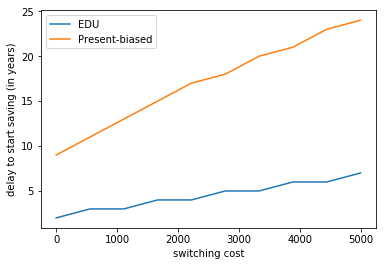

In [22]:
plt.figure()
plt.plot(ks,optedus,label='EDU')
plt.plot(ks,optpbus,label='Present-biased')
plt.xlabel('switching cost')
plt.ylabel('delay to start saving (in years)')
plt.legend()
plt.show()

## Variation with match rate


In [23]:
mus = np.linspace(0,0.5,10)
optedus = []
optpbus = []
for mui in mus:
    optedu, V = solve_edu(delta,gamma,k,s,mui) 
    optedus.append(optedu)
    optpbu = solve_pbu(beta,delta,gamma,k,s,mui,V)
    optpbus.append(optpbu)

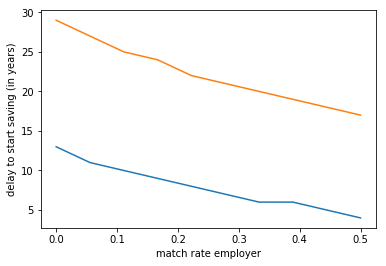

In [24]:
plt.figure()
plt.plot(mus,optedus,label='EDU')
plt.plot(mus,optpbus,label='Present-biased')
plt.xlabel('match rate employer')
plt.ylabel('delay to start saving (in years)')
plt.show()